In [ ]:
import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import nltk
import nltk
from tensorflow.keras.regularizers import l2
nltk.download('punkt')
nltk.download('stopwords')

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, GRU, LSTM, Bidirectional
from keras.layers import Embedding
from keras.initializers import Constant
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_1 = pd.read_json("/content/drive/MyDrive/saracsm detection/Sarcasm_Headlines_Dataset.json", lines=True)
data_2 = pd.read_json("/content/drive/MyDrive/saracsm detection/Sarcasm_Headlines_Dataset_v2.json", lines=True)
data =  pd.concat([data_1, data_2])
data.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [ ]:
def clean_text(text):
    text = text.lower()

    pattern = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    text = pattern.sub('', text)
    text = " ".join(filter(lambda x:x[0]!='@', text.split()))
    emoji = re.compile("["
                           u"\U0001F600-\U0001FFFF"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)

    text = emoji.sub(r'', text)
    text = text.lower()
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"that's", "that is", text)
    text = re.sub(r"what's", "what is", text)
    text = re.sub(r"where's", "where is", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"don't", "do not", text)
    text = re.sub(r"did't", "did not", text)
    text = re.sub(r"can't", "can not", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"couldn't", "could not", text)
    text = re.sub(r"have't", "have not", text)
    text = re.sub(r"[,.\"\'!@#$%^&*(){}?/;`~:<>+=-]", "", text)
    return text

In [ ]:
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

def CleanTokenize(df):
    head_lines = list()
    lines = df["headline"].values.tolist()

    for line in lines:
        line = clean_text(line)
        # tokenize the text
        tokens = word_tokenize(line)
        # remove puntuations
        table = str.maketrans('', '', string.punctuation)
        stripped = [w.translate(table) for w in tokens]
        # remove non alphabetic characters
        words = [word for word in stripped if word.isalpha()]
        stop_words = set(stopwords.words("english"))
        # remove stop words
        words = [w for w in words if not w in stop_words]
        head_lines.append(words)
    return head_lines

head_lines = CleanTokenize(data)
head_lines[0:10]

[['former',
  'versace',
  'store',
  'clerk',
  'sues',
  'secret',
  'black',
  'code',
  'minority',
  'shoppers'],
 ['roseanne',
  'revival',
  'catches',
  'thorny',
  'political',
  'mood',
  'better',
  'worse'],
 ['mom',
  'starting',
  'fear',
  'sons',
  'web',
  'series',
  'closest',
  'thing',
  'grandchild'],
 ['boehner',
  'wants',
  'wife',
  'listen',
  'come',
  'alternative',
  'debtreduction',
  'ideas'],
 ['jk', 'rowling', 'wishes', 'snape', 'happy', 'birthday', 'magical', 'way'],
 ['advancing', 'worlds', 'women'],
 ['fascinating', 'case', 'eating', 'labgrown', 'meat'],
 ['ceo', 'send', 'kids', 'school', 'work', 'company'],
 ['top', 'snake', 'handler', 'leaves', 'sinking', 'huckabee', 'campaign'],
 ['fridays', 'morning', 'email', 'inside', 'trumps', 'presser', 'ages']]

**Visualization**

(-0.5, 999.5, 499.5, -0.5)

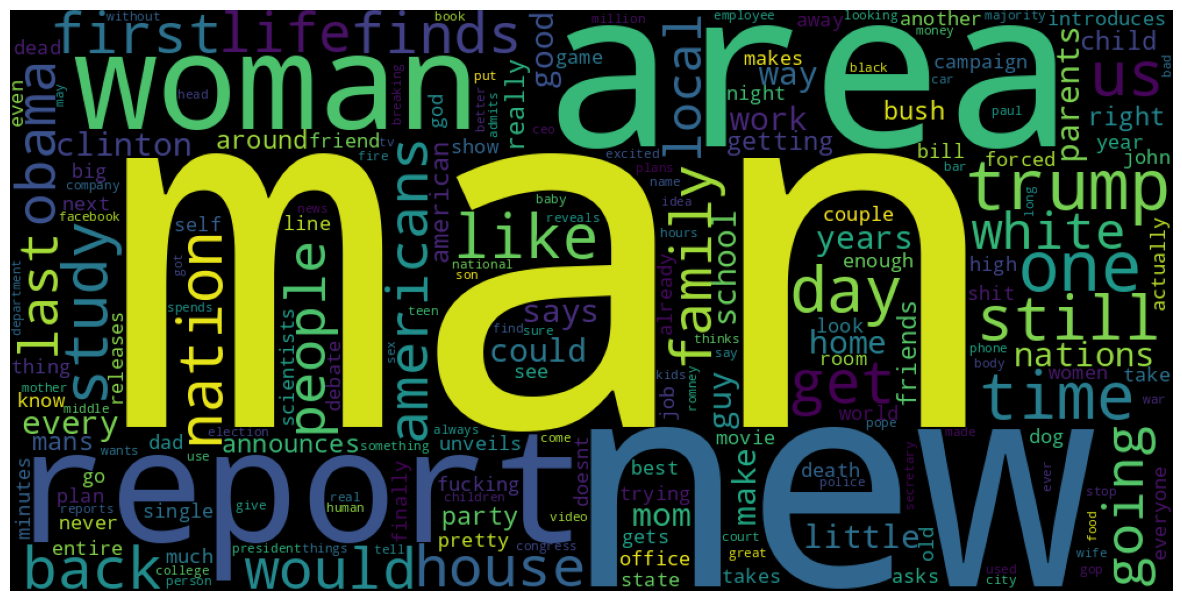

In [ ]:
from collections import Counter
from wordcloud import WordCloud, ImageColorGenerator
pos_data = data.loc[data['is_sarcastic'] == 1]
pos_head_lines = CleanTokenize(pos_data)
pos_lines = [j for sub in pos_head_lines for j in sub]
word_could_dict=Counter(pos_lines)

wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(word_could_dict)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")

**Train-test split**

In [ ]:
validation_split = 0.2
max_length = 25


tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(head_lines)
sequences = tokenizer_obj.texts_to_sequences(head_lines)

word_index = tokenizer_obj.word_index
print("unique tokens - ",len(word_index))
vocab_size = len(tokenizer_obj.word_index) + 1
print('vocab size -', vocab_size)

lines_pad = pad_sequences(sequences, maxlen=max_length, padding='post')
sentiment =  data['is_sarcastic'].values

indices = np.arange(lines_pad.shape[0])
np.random.shuffle(indices)
lines_pad = lines_pad[indices]
sentiment = sentiment[indices]

num_validation_samples = int(validation_split * lines_pad.shape[0])

X_train_pad = lines_pad[:-num_validation_samples]
y_train = sentiment[:-num_validation_samples]
X_test_pad = lines_pad[-num_validation_samples:]
y_test = sentiment[-num_validation_samples:]

unique tokens -  28657
vocab size - 28658


In [ ]:
print('Shape of X_train_pad:', X_train_pad.shape)
print('Shape of y_train:', y_train.shape)

print('Shape of X_test_pad:', X_test_pad.shape)
print('Shape of y_test:', y_test.shape)

Shape of X_train_pad: (44263, 25)
Shape of y_train: (44263,)
Shape of X_test_pad: (11065, 25)
Shape of y_test: (11065,)


 **LOAD GloVe MODEL**

In [ ]:
embeddings_index = {}
embedding_dim = 100
GLOVE_FILE = "/content/drive/MyDrive/saracsm detection/glove.6B.100d.txt"  # Specify the full path to the GloVe file

# Open the GloVe file directly
with open(GLOVE_FILE, encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print('Found %s word vectors.' % len(embeddings_index))







Found 400000 word vectors.


 **embedding layer**

In [ ]:
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
c = 0
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        c+=1
        embedding_matrix[i] = embedding_vector
print(c)

24993


In [ ]:
embedding_layer = Embedding(len(word_index) + 1,
                            embedding_dim,
                            weights=[embedding_matrix],
                            input_length=max_length,
                            trainable=False)

**RNN MODEL**

In [ ]:
model = Sequential()
model.add(embedding_layer)
model.add(Bidirectional(LSTM(256, dropout=0.2, recurrent_dropout=0.25)))
#model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

print('Summary of the built model...')
print(model.summary())


Summary of the built model...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 25, 100)           2865800   
                                                                 
 bidirectional (Bidirection  (None, 512)               731136    
 al)                                                             
                                                                 
 dense (Dense)               (None, 1)                 513       
                                                                 
Total params: 3597449 (13.72 MB)
Trainable params: 731649 (2.79 MB)
Non-trainable params: 2865800 (10.93 MB)
_________________________________________________________________
None


In [ ]:
history = model.fit(X_train_pad, y_train, batch_size=32, epochs=35, validation_data=(X_test_pad, y_test), verbose=1)

Epoch 1/35
1384/1384 [==============================] - 590s 421ms/step - loss: 0.4959 - acc: 0.7579 - val_loss: 0.4181 - val_acc: 0.8101
Epoch 2/35
1384/1384 [==============================] - 584s 422ms/step - loss: 0.3930 - acc: 0.8196 - val_loss: 0.3727 - val_acc: 0.8337
Epoch 3/35
1384/1384 [==============================] - 588s 425ms/step - loss: 0.3285 - acc: 0.8549 - val_loss: 0.3251 - val_acc: 0.8602
Epoch 4/35
1384/1384 [==============================] - 583s 421ms/step - loss: 0.2653 - acc: 0.8868 - val_loss: 0.2745 - val_acc: 0.8871
Epoch 5/35
1384/1384 [==============================] - 570s 412ms/step - loss: 0.2078 - acc: 0.9153 - val_loss: 0.2494 - val_acc: 0.9032
Epoch 6/35
1384/1384 [==============================] - 564s 407ms/step - loss: 0.1673 - acc: 0.9334 - val_loss: 0.2188 - val_acc: 0.9209
Epoch 7/35
1384/1384 [==============================] - 562s 406ms/step - loss: 0.1354 - acc: 0.9470 - val_loss: 0.2018 - val_acc: 0.9310
Epoch 8/35
1384/1384 [============

In [ ]:
# Evaluate the model on the testing dataset
testing_loss, testing_accuracy = model.evaluate(X_test_pad, y_test)

# Print the testing accuracy with three digits after the decimal point
print(f"Testing Accuracy: {testing_accuracy:.3f}")


In [ ]:
# Plot results
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
def predict_sarcasm(s):
    x_final = pd.DataFrame({"headline":[s]})
    test_lines = CleanTokenize(x_final)
    test_sequences = tokenizer_obj.texts_to_sequences(test_lines)
    test_review_pad = pad_sequences(test_sequences, maxlen=max_length, padding='post')
    pred = model.predict(test_review_pad)
    pred*=100
    if pred[0][0]>=50: return "It's a sarcasm!"
    else: return "It's not a sarcasm."

In [ ]:
predict_sarcasm("I was depressed. He asked me to be happy. I am not depressed anymore.")

1/1 [==============================] - 0s 347ms/step


"It's a sarcasm!"

In [ ]:
predict_sarcasm("I am not happy with the matter")

1/1 [==============================] - 0s 258ms/step


"It's not a sarcasm."

In [ ]:
predict_sarcasm("You just broke my car window. Great job.")

1/1 [==============================] - 0s 23ms/step


"It's a sarcasm!"

In [ ]:
predict_sarcasm("Irad is sitting alone ")

1/1 [==============================] - 0s 23ms/step


"It's not a sarcasm."